# Projet Python pour le data scientist : Prévision des prix des Airbnb
#### Réalisé par M.Blazevic, E.Bordais, C.Nadler, C.Voisin

## 0. Import modules et base de données

In [2]:
%pip install shap
%pip install xgboost
%pip install geopandas
%pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.5/436.5 kB 1.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 848.0/848.0 kB 1.8 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [1246 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.macosx-10.9-x86_64-cpython-39
      creating build/lib.macosx-10.9-x86_64-cpython-39/xgboost
      copying xgboost/rabit.py -> build/lib.macosx-10.9-x86_64-cpython-39/xgboost
      copying xgboost/callback.py -> build/lib.macosx-10.9-x86_64-cpython-39/xgboost
      copying xgboost/config.py -> build/lib.macosx-10.9-x86_64-cpython-39/xgboost
      copying xgboost/compat.py -> build/lib.macosx-10.9-x86_64-cpython-39/xgboost
      copying xgboost/_typi

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from string import ascii_letters
import itertools
import collections
import nltk
from nltk.corpus import stopwords 
from wordcloud import WordCloud
import warnings
import geopy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import sklearn
import pickle
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
import shap
import plotly.express as px
import geopandas as gpd 


%matplotlib inline


ModuleNotFoundError: No module named 'wordcloud'

In [133]:

data = pd.read_csv('airbnb-listings3.csv' , sep=';', low_memory= False)
data

ParserError: Error tokenizing data. C error: out of memory

On supprime les features qui ne sont pas utiles

In [ ]:
df = data.drop(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Summary', 
              'Experiences Offered', 'Thumbnail Url', 'House Rules', 'Medium Url',
              'Picture Url', 'XL Picture Url', 'Host URL', 'Host Location', 
              'Host About', 'Host Acceptance Rate', 'Host Thumbnail Url', 
              'Host Picture Url', 'Host Neighbourhood', 'Host Listings Count',
               'Host Verifications','Neighbourhood Group Cleansed', 'State', 
                'Market', 'Smart Location', 'Country Code', 'Country', 
               'Calendar last Scraped', 'First Review', 'Last Review', 
                'Jurisdiction Names', 'Features', 'License', 'Interaction', 'Host Name',
                'Monthly Price', 'Weekly Price'
               ], axis=1)

In [ ]:
df.head()

On a donc maintenant 55 features

In [ ]:
df.columns

## 1. Statistiques descriptives de la base de données 

### 1.0 Premières statistiques

In [ ]:
#On abandonne les colonnes où les prix sont nuls pour éviter de fausser l'analyse
df=df[df['Price']!=0]

In [ ]:
df['Price'].describe()

On remarque que le prix moyen par nuit est de 94€, avec un prix minimal de 8€, qui paraît assez incohérent avec les tarifs habituels.

Traçons la répartition des prix des Airbnb parisiens

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df['Price'], kde=True, bins=int(100))
plt.title ('Répartition des prix des AirBnb à Paris')
plt.xlabel('Prix')
plt.ylabel('Quantité')

In [ ]:
#Pourcentage des airbnb ayant un prix inférieur à 200€
len(df.loc[df['Price']<200])/len(df) * 100

On observe que la plus grande partie (environ 93%) des AirBnb ont un prix inférieur à 200€ par nuit.  Traçons désormais les distributions de prix en dessous et au dessus de ce seuil. 

In [ ]:
warnings.simplefilter('ignore')

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

ax0 = sns.distplot(df[df['Price'] <= 200]['Price'], ax=axs[0])
ax0.set_title('Distribution des prix inférieurs à 200 euros')

ax1 = sns.distplot(df[df['Price'] > 200]['Price'], ax=axs[1])
ax1.set_title('Distribution des prix supérieurs à 200 euros')

Qu'est ce qui influence le plus le prix d'un Airbnb ? 
Nous avons naturellement pensé à plusieurs axes tels que : 
- sa taille : nombre de chambres, de personnes qu'il peut accueillir, superficie
- sa localisation : quartier 
- qualité de l'hébergement : matériel et services disponibles
- qualité de l'hôte


##### Quelles sont les variables les plus corrélées au prix ?

In [ ]:
#on ne garde que les variables numériques
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

In [ ]:
sns.set_theme(style="white")

# Matrice de corrélation
corr = df_num.corr()

# Génération d'un masque pour la partie supérieure du triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Mise en place de la figure
f, ax = plt.subplots(figsize=(11, 9))

# Création d'une palette de couleurs
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Tracé de la heatmap avec le masque et les bonnes dimensions
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#Variables numériques les plus corrélées avec le prix

var_corr = df_num.corr()['Price']
var = var_corr[abs(var_corr) > 0.2].sort_values(ascending=False)
print("Voici les {} variables les plus fortement corrélées avec le prix par nuit (en ignorant la variable 'Price'):\n{}".format(len(var), var))

Ainsi, les variables les plus corrélées au prix sont les frais de nettoyage, la capacité d'accueil, le nombre de chambres, de lits et de salles de bain, la caution, la superficie de l'appartement, le nombre d'invités inclus dans l'annonce de base, le nombre d'annonces de l'hôte, ainsi que l'arrondissement.

### 1.1 Influence de la localisation

In [ ]:
df.columns

Après une rapide analyse, on se rend compte que la variable Neighbourhood Cleansed est moins précise que Neighbourhood
(20 valeurs contre 64) mais elle semble éliminer certaines erreurs et doublons (par exemple, le quartier Cannesqui qui n'existe pas, le 15ème arrondissement qui groupe avec d'autre quartiers...). On utilisera donc cette variable là. 

In [ ]:
df['Neighbourhood Cleansed'].describe()

In [ ]:
#On produit un tableau qui indique le nombre et le prix moyen des Airbnb par quartier
df_nb = df.groupby('Neighbourhood Cleansed').agg({'Neighbourhood Cleansed':'count', 'Price':'mean'})
df_nb.columns = ['count', 'mean_price']
df_nb.reset_index(inplace=True)
df_nb.sort_values('count', ascending=False, ignore_index=True, inplace=True)

In [ ]:
df_nb

On s'aperçoit donc que les prix varient fortement entre les différents quartiers de Paris. On s'intéresse désormais au prix par arrondissement, pour ensuite faire de la visualisation sur carte. 

In [ ]:
#Toutes les valeurs prises par la variable Zipcode
df['Zipcode'].unique()

On remarque que il y a beaucoup d'imperfections sur cette variable, il faut donc la nettoyer : 
- enlever les Airbnb situés en banlieue (zipcode commencant par 92, 94, ...) 
- regrouper les 75018.0 et 75018 

In [ ]:
#on créé la variable arrondissement, on lui donne la valeur 0 par défaut
df['Arrondissement']=0

In [ ]:
#on attribue la bonne valeur à la variable arrondissement

df.loc[df["Zipcode"]=="75001", "Arrondissement"] = 1
df.loc[df["Zipcode"]=="75001.0", "Arrondissement"] = 1
df.loc[df["Zipcode"]=="75002", "Arrondissement"] = 2
df.loc[df["Zipcode"]=="75002.0", "Arrondissement"] = 1
df.loc[df["Zipcode"]=="75003", "Arrondissement"] = 3
df.loc[df["Zipcode"]=="75003.0", "Arrondissement"] = 3
df.loc[df["Zipcode"]=="75004", "Arrondissement"] = 4
df.loc[df["Zipcode"]=="75004.0", "Arrondissement"] = 4
df.loc[df["Zipcode"]=="75005", "Arrondissement"] = 5
df.loc[df["Zipcode"]=="75005.0", "Arrondissement"] = 5
df.loc[df["Zipcode"]=="75006", "Arrondissement"] = 6
df.loc[df["Zipcode"]=="75006.0", "Arrondissement"] = 6
df.loc[df["Zipcode"]=="75007", "Arrondissement"] = 7
df.loc[df["Zipcode"]=="75007.0", "Arrondissement"] = 7
df.loc[df["Zipcode"]=="75008", "Arrondissement"] = 8
df.loc[df["Zipcode"]=="75008.0", "Arrondissement"] = 8
df.loc[df["Zipcode"]=="75009", "Arrondissement"] = 9
df.loc[df["Zipcode"]=="75009.0", "Arrondissement"] = 9
df.loc[df["Zipcode"]=="75010", "Arrondissement"] = 10
df.loc[df["Zipcode"]=="75010.0", "Arrondissement"] = 10
df.loc[df["Zipcode"]=="75011", "Arrondissement"] = 11
df.loc[df["Zipcode"]=="75011.0", "Arrondissement"] = 11
df.loc[df["Zipcode"]=="75012", "Arrondissement"] = 12
df.loc[df["Zipcode"]=="75012.0", "Arrondissement"] = 12
df.loc[df["Zipcode"]=="75013", "Arrondissement"] = 13
df.loc[df["Zipcode"]=="75013.0", "Arrondissement"] = 13
df.loc[df["Zipcode"]=="75014", "Arrondissement"] = 14
df.loc[df["Zipcode"]=="75014.0", "Arrondissement"] = 14
df.loc[df["Zipcode"]=="75015", "Arrondissement"] = 15
df.loc[df["Zipcode"]=="75015.0", "Arrondissement"] = 15
df.loc[df["Zipcode"]=="75016", "Arrondissement"] = 16
df.loc[df["Zipcode"]=="75016.0", "Arrondissement"] = 16      
df.loc[df["Zipcode"]=="75116", "Arrondissement"] = 16
df.loc[df["Zipcode"]=="75116.0", "Arrondissement"] = 16               
df.loc[df["Zipcode"]=="75017", "Arrondissement"] = 17
df.loc[df["Zipcode"]=="75017.0", "Arrondissement"] = 17           
df.loc[df["Zipcode"]=="75018", "Arrondissement"] = 18
df.loc[df["Zipcode"]=="75018.0", "Arrondissement"] = 18    
df.loc[df["Zipcode"]=="75019", "Arrondissement"] = 19
df.loc[df["Zipcode"]=="75019.0", "Arrondissement"] = 19   
df.loc[df["Zipcode"]=="75020", "Arrondissement"] = 20
df.loc[df["Zipcode"]=="75020.0", "Arrondissement"] = 20 

In [ ]:
df['Arrondissement'].unique()

In [ ]:
#on enlève tous les Airbnb qui n'ont pas été affectés à une valeur
df = df[df['Arrondissement']> 0]

Commentaire : on avait auparavant 54513 lignes dans le dataframe, on en a désormais 53731, on a donc perdu 800 données en nettoyant la variable liée aux arrondissements. Cette perte n'est pas significative. 

In [ ]:
#On affiche le nombre d'airbnb et le prix moyen des airbnb par arrondissement
df_arr = df.groupby('Arrondissement').agg({'Arrondissement':'count', 'Price':'mean'})
df_arr.columns = ['Count', 'Mean_price']
df_arr.reset_index(inplace=True)
df_arr.sort_values('Mean_price', ascending=False, ignore_index=True, inplace=True)

In [ ]:
df_arr

On remarque que les arrondissements les plus chers de Paris sont le 8e, le 6e et le 1er. On décide de visualiser sur une carte les prix, afin de mieux comprendre cette distribution.

Pour la visualisation par carte, on doit d'abord télécharger un fichier geojson qui délimite les arrondissements parisiens. Ensuite, on le superpose à une carte de Paris et grâce à mapbox on peut la rendre interactive et afficher les données. 

In [ ]:
geojson = gpd.read_file('arrondissements.geojson')

Le fichier geojson est un dataframe avec des informations géographiques. On peut donc le fusionner avec le dataframe df_arr qui regroupe le prix moyen des Airbnb par arrondissement. 

In [ ]:
geojson.head()

In [ ]:
df_final = geojson.merge(df_arr, left_on="c_ar", right_on="Arrondissement", how="outer")

In [ ]:
fig1 = px.choropleth_mapbox(df_final, locations = 'Arrondissement',
                            featureidkey = 'properties.c_ar',
                            geojson= geojson,
                            color=df_final['Mean_price'],
                            color_continuous_scale="PuRd",
                            range_color=[65,155],
                            hover_name='Arrondissement',
                            hover_data=['Mean_price'],
                            labels = {'Mean_price' : "Prix moyen par nuit"},
                            title="Prix des Airbnb par arrondissement",
                            mapbox_style="open-street-map",
                            center= {'lat':48.866669, 'lon':2.33333},
                            zoom =10.5, 
                            opacity= 0.6)

fig1.show()

Les différences de prix selon les arrondissements sont-elles liées à la différence des prix de l'immobilier ? Pour répondre à cette question, nous créons une comparaison avec les loyers parisiens à partir d'une base de données scrapée sur Superimmo, qui regroupe toutes les logements disponibles à la location à Paris et publiés sur ce site, soit un millier. 

In [ ]:
loy = pd.read_csv('loyers.csv')

In [ ]:
loy = loy[loy['Loyer (€)'] < 20000]

In [ ]:
loy['Loyer par m²'] = loy['Loyer (€)'] / loy['Surface (m²)']

In [ ]:
loy.describe()

In [ ]:
loy_nb = loy.groupby('Arrrondissement').agg({'Arrrondissement' : 'count',
                                          'Loyer (€)' : 'mean',
                                         'Loyer par m²' : 'mean', 
                                         'Surface (m²)' : 'mean'} )
loy_nb.columns = ["Nombre d'annonces", 'Loyer moyen (€)', 
                 'Loyer moyen par m² (€)', 'Surface moyenne (m²)']
loy_nb = loy_nb.reset_index()

In [ ]:
loy_final = geojson.merge(loy_nb, left_on="c_ar", right_on="Arrrondissement", how="outer") 

In [ ]:
fig2 = px.choropleth_mapbox(loy_final, locations = 'Arrrondissement',
                            featureidkey = 'properties.c_ar',
                            geojson= geojson,
                            color=loy_final['Loyer moyen par m² (€)'],
                            color_continuous_scale="PuRd",
                            range_color=[30,46],
                            hover_name='Arrrondissement',
                            hover_data=['Loyer moyen (€)', 
                                        'Surface moyenne (m²)', 
                                        'Loyer moyen par m² (€)'],
                            title="Loyer moyen par m² selon l'arrondissement",
                            mapbox_style="open-street-map",
                            center= {'lat':48.866669, 'lon':2.33333},
                            zoom =10.5, 
                            opacity= 0.6)

fig1.show()
fig2.show()

On remarque que bien qu'il n'y ait pas une déconnexion totale entre les prix des Airbnb et les prix des loyers comparativement, certains quartiers sont davantage prisés par les touristes (le VIIe) et d'autres par les habitants (le Ier, le Xe). 

### 1.2 Disponbilité

In [ ]:
sns.histplot(data=df["Availability 365"],bins=int(50))
plt.title('Histogramme du nombre de jours de disponibilité des Airbnb', weight='bold')
plt.xlabel('Disponibilité (en jours)')
plt.ylabel('Nombre')

In [ ]:
a = len(df[df['Availability 365']>300])
b = len(df[df['Availability 365']<60])
c = len(df[df['Availability 365']==0])
a,b,c

On remarque que près de la moitié des Airbnb sont loués moins de 60 jours par an, ce qui semble correspondre au concept de base de Airbnb - c'est à dire louer sa maison ou son appartement quand on est en vacances ou autre pour arrondir ses fins de mois. 
Cependant, on voit aussi que plus de 12 000 Airbnb sont loués plus de 300 jours par an. On observe donc que certaines personnes louent quasiment en continuité leur logement sur Airbnb pour de courtes périodes, alors qu'ils pourraient le louer sur des longues durées. On peut donc supposer qu'il est plus intéressant financièrement de louer son bien sur Airbnb que en agence par exemple.

### 1.3 Influence de la taille du logement

On a vu dans la matrice de corrélation que la "taille" du logement était fortement corrélée au prix ce qui semble logique. On peut faire quelques statistiques descriptives pour avoir un aperçu des différentes tailles de logement. 

In [ ]:
#On enlève les valeurs manquantes au niveau du nombre de salles de bain
df = df[df['Bathrooms'].notnull()]

Dans la partie modélisation, nous continuerons à enlever les lignes où il n'y a pas de données à propos du nombre de chambres, de lits, des frais de nettoyage, du dépôt de sécurité... Nous ne le faisons pas maintenant car cela ne laisse qu'environ 19000 lignes, et enlève des données essentielles pour l'analyse des reviews menée en partie 1.4.

In [ ]:
#Nouveau data frame uniquement avec les airbnb où le nb de metres carrés est renseigné
df_feet = df.loc[(df['Square Feet'] !=0)]
len(df_feet)

In [ ]:
#Répartition du nombres de personnes que peuvent accueillir les Airbnb, pour savoir à quels types de logement on traite
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(df_feet['Accommodates'], bins=int(40))
plt.title ('Nombre de personnes que peuvent accueillir les airbnb', weight='bold')
plt.xlabel('Nombre de personnes')
plt.ylabel('Quantité')


La majorité des Airbnb accueillent 2 ou 4 personnes.

In [ ]:
df_feet['Square Feet'].describe()


- il manque énormément de données sur les superficies : sur plus de 50 000 données à la base, on en a à peine 1500
- Le maximum de surface est de 15000 square feet ce qui correspond à 1393m2, probablement un erreur de saisie donc on va enlever tous les logements ayant une superficie supérieure à 2500 square feet (soit 232m2).

In [ ]:
df_feet = df_feet.loc[(df_feet['Square Feet'] < 2500)]

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.histplot(data=df_feet['Square Feet'], kde=True, bins=int(80))
plt.title ('Répartition de la surface des logements', weight='bold')
plt.xlabel('Nombre')
plt.ylabel('Surface (en m2)')

A cause du nombre très important de données manquantes sur les surfaces des logements, on va désormais s'intéresser au nombre de chambres, de salles de bains, etc... qui sont également des bons indicateurs de la taille du logement.


In [ ]:
df['Bathrooms'] = df['Bathrooms'].astype(int)

In [ ]:
df['Bathrooms'].unique()

In [ ]:
df['Bedrooms'].unique()

In [ ]:
df_bed = df.groupby('Bedrooms').agg({'Bedrooms':'count'})
df_bed.columns = ['count']
df_bed.reset_index(inplace=True)
df_bed.sort_values('count', ascending=False, ignore_index=True, inplace=True)
df_bed

In [ ]:
df_bath = df.groupby('Bathrooms').agg({'Bathrooms':'count'})
df_bath.columns = ['count']
df_bath.reset_index(inplace=True)
df_bath.sort_values('count', ascending=False, ignore_index=True, inplace=True)
df_bath

Plus de 11 000 logements n'ont pas de chambre, on peut donc en déduire que ce sont des studios. La plus grande majorité des logements ont une unique salle de bain. 

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.hist([df["Bedrooms"], df["Bathrooms"]], label=['Nombre de chambres', 'Nombre de salles de bains'], edgecolor = 'white')
plt.title("Histogramme du nombre de salles de bains et de chambres des Airbnb à Paris",size=15, weight='bold')
plt.legend()


### 1.4 Les reviews

On s'intéresse désormais aux revues des annonces, qui sont à priori essentielles lors de la réservation d'un bien.

In [ ]:
df_review = df[['Number of Reviews', 'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Reviews per Month', 'Price']]

In [ ]:
plt.figure(figsize=(7,7))
sns.scatterplot(x="Number of Reviews", y="Price", data=df_review)

plt.xlabel("Number of Reviews")
plt.ylabel("Price")
plt.title("Prix en fonction du nombre de reviews sur l'appartement",size=15, weight='bold')

On remarque clairement une corrélation négative entre le nombre de reviews et le prix. Les appartements les moins chers ont beaucoup plus de reviews. Plus précisement, pour des appartements ayant un prix inférieur à 200€, un nombre conséquent d'appartements ont plus de 200 reviews tandis que pour des appartements ayant un prix supérieur a 300€, aucun appartement n'a plus de 200 reviews.
 Cela peut s'expliquer par une demande moins importante pour les appartements plus chers, qui au final ont donc moins de reviews. Également, un loueur peut se permettre de mettre en vente son appartement moins souvent si le prix est très élevé (et donc moins de réservations, moins de reviews).

In [ ]:

# On regarde la distribution sur les différentes notes données 

fig, ax = plt.subplots(2, 3)
fig.tight_layout()

ax[0, 0].hist(data["Review Scores Value"]) #row=0, col=0
ax[0, 0].set_title('Valeur')
ax[1, 0].hist(data["Review Scores Accuracy"]) #row=1, col=0
ax[1, 0].set_title('Précision')
ax[0, 1].hist(data["Review Scores Cleanliness"]) #row=0, col=1
ax[0, 1].set_title('Propreté')
ax[1, 1].hist(data["Review Scores Communication"]) #row=1, col=1
ax[1, 1].set_title('Communication')
ax[1, 2].hist(data["Review Scores Location"]) #row=1, col=2
ax[1, 2].set_title('Localisation')
ax[0, 2].hist(data["Review Scores Rating"]) #row=2, col=2
ax[0, 2].set_title('Rating')
plt.show()

Ensuite, pour déterminer les signaux de qualité transmis par les annonces, nous allons analyser ces dernières en regardant les mots les plus fréquemment utilisés pour décrire le bien mis à disposition sur la plateforme.

In [ ]:
#On regarde le nombre d'offres qui n'ont pas de description 
data['Description'].isnull().sum()

In [ ]:
# Si on ne veut pas fausser l'analyse textuelle et avoir un message d'erreur, il faut enlever les lignes qui correspondent à des valeur manquantes 
def transform(lst) :
  return ([i for item in lst for i in item.lower().split()])
full_reviews = transform(data['Description'].fillna(""))

On peut maintenant s'intéresser à la fréquence des mots sur les descriptions d'appartements, dans le but de regarder le lien potentiel avec les prix des Airbnb


In [ ]:

# Fréquence de mots

nb_mots = collections.Counter(full_reviews) 

frq_mots = pd.DataFrame(nb_mots.most_common(8),
                             columns=['mots', 'occurences'])

frq_mots.head()


On obtient un résultat peu étonnant : les mots qui reviennent le plus sont des mots de liaison, des déterminants ou des conjonctions de coordination (« et »). 
Cependant, ces mots ne vont pas nous être utiles pour faire de l'analyse textuelle sur la qualité des descriptions. 
On va donc essayer d'enlever ces « stopwords », via la méthode vue en cours. 

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words(['french','english']))


In [ ]:
# On ajoute des stop words à la liste initiale, qui était mal configurée 

new_stopwords = ['1', 'one', '2', 'two', 'deux', '3','4','5', '10', '-', ':', ',', 'tout', '!', '.', "d'un", 'rue', 'pied', 'min', 'also', 'Paris', 'paris', 'paris.','paris,', 'parisian', 'place', 'flat', 'floor', 'room', 'bed', 'lit', 'chambre', 'situé', 'logement', 'salle', 'appartement', "l'appartement", 'apartment', 'minutes', 'métro', 'metro', 'studio','kitchen']
new_stopwords_list = stop_words.union(new_stopwords)

print(new_stopwords_list)


In [ ]:
mots_listing = [word for word in full_reviews if word not in new_stopwords_list]
nb_mots_listing = collections.Counter(mots_listing)
nb_mots_listing_df = pd.DataFrame(nb_mots_listing.most_common(33),
                             columns=['words', 'count'])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

nb_mots_listing_df.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="blue")

ax.set_title("Mots les plus fréquents")

plt.show()


On ajoute aussi un wordcloud pour mieux visualiser les mots importants dans les reviews. Il permet de souligner l'importance d'équipements tels que le wifi, la télévision, les salles de bain, mais aussi la proximité avec les restaurants ou les bars.

In [ ]:
text = ''.join(mots_listing)

word_cloud = WordCloud(collocations = False, stopwords = new_stopwords_list, background_color = 'white', colormap = 'Set3').generate(text)

plt.imshow(word_cloud, interpolation='bilinear' )
plt.axis("off")
plt.show()

## 2. Modélisation

### 2.0 Nettoyage plus approfondi du dataset

Puisque les biens traités sont tous uniques, une valeur manquante concernant certaines variables (prix, du nombre de personnes accueillies, dépôt de sécurité...) ne peut pas être remplacée par une valeur moyenne ou médiane ("imputing"). On décide de supprimer les lignes si l'une des variables suivantes est manquante.

In [ ]:
df.isnull().sum()

In [ ]:
df.info()

In [ ]:
df = df[df['Cleaning Fee'].notnull()]
df = df[df['Security Deposit'].notnull()]

df = df[df['Bedrooms'].notnull()]
df = df[df['Amenities'].notnull()]
df = df[df['Review Scores Rating'].notnull()]
df = df[df['Host Since'].notnull()]
df = df[df['Host Response Time'].notnull()]

In [ ]:
df.isnull().sum()

In [ ]:
df.info()

Maintenant qu'il n'y a plus de valeurs manquantes pour des colonnes essentielles à notre modèle, nous allons transformer des variables qualitatives en variables quantitatives. Par exemple, la variable "Cancellation Policy" peut jouer un rôle très important dans la réservation d'un Airbnb - on aura plutôt tendance à favoriser un Airbnb avec des conditions d'annulation flexibles en cas d'imprévu.

Après lecture des indications liées aux différents modes d'annulation et de remboursement, on décide d'attribuer un score entre 1 et 5 aux annonces ; 5 correspond à "super_strict60", qui laisse très peu de flexibilité aux clients, et 1 à "flexible", qui permet d'annuler jusqu'à 24h à l'avance sans frais.

Il n'y a aucune annonce correspondant à "super_strict_60", donc tous nos listings auront un score entre 1 et 4. On crée la nouvelle variable, puis on la fait correspondre aux politiques d'annulation.

In [ ]:
df["Score Annulation"] = 0

In [ ]:
df["Cancellation Policy"].unique()

In [ ]:
df.loc[df['Cancellation Policy']=='flexible', "Score Annulation"] = 1 
df.loc[df['Cancellation Policy']=='moderate', "Score Annulation"] = 2
df.loc[df['Cancellation Policy']=='strict', "Score Annulation"] = 3
df.loc[df['Cancellation Policy']=='super_strict_30', "Score Annulation"] = 4 

In [ ]:
df

De même, on crée une variable numérique Réactivité qui correspond à la qualité de "Host Response Time" ; plus l'hôte répond rapidement, plus le score est bas.

In [ ]:
df["Reactivite"] = 0

In [ ]:
df["Host Response Time"].unique()

In [ ]:
df.loc[df['Host Response Time']=='within an hour', "Reactivite"] = 1 
df.loc[df['Host Response Time']=='within a few hours', "Reactivite"] = 2
df.loc[df['Host Response Time']=='within a day', "Reactivite"] = 3
df.loc[df['Host Response Time']=='a few days or more', "Reactivite"] = 4 

Enfin, on crée une variable "Popu Arrondissement" qui correspond au nombre d'annonces par arrondissement ; en effet, cette variable peut influencer le prix d'une annonce et aussi favoriser une réservation par rapport à une autre annonce.

In [ ]:
df["Popu Arrondissement"]=0

In [ ]:
df['Arrondissement'].unique()

In [ ]:
listepopu = df.groupby(['Arrondissement']).agg({'Arrondissement':'count'})
listepopu


In [ ]:
df['Popu Arrondissement'] = df['Arrondissement'].groupby(df['Arrondissement']).transform('count')

In [ ]:
df['Popu Arrondissement'].unique()

In [ ]:
df

## 2.1 Préparation du modèle

Le dataset étant de taille assez conséquente, nous allons le "shuffler" puis le diviser en 5, afin d'avoir 5 samples iid.

In [ ]:
df_shuffle = df.sample(frac = 1)
df_shuffle

In [ ]:
df_splits = np.array_split(df_shuffle, 5)
df_splits

In [ ]:
df1 = df_splits[0]

On travaillera donc sur 5 subsets.

### 2.2 Traitement du 1er subset

Nous traiterons uniquement ici le 1er subset pour des questions de simplification ; de plus, les 5 subsets étant iid, en traiter un revient à priori à traiter n'importe lequel.
En reprenant les graphes de la partie 1, on remarque que la majorité des Airbnb accueillent 8 personnes ou moins, et que la majorité des prix sont en dessous de 400 euros par nuit. Pour éviter les outliers, on sélectionne les parties du dataframe qui respectent ces conditions.

In [ ]:
model1 = df1[(df1['Price'] < 400) & (df1['Accommodates'] <= 8)]
list(model1.columns)

In [ ]:
df1['Price'].mean()

Le prix moyen par nuit du subset est de 100 euros par nuit.

On sélectionne les colonnes que l'on gardera pour les régressions ; les colonnes suivantes sont celles que l'on supprime du modèle.

In [134]:
drop_cols = ['Name','Space','Description','Neighborhood Overview',
 'Notes',
 'Transit',
 'Access',
 'Host ID',
 'Host Since',
 'Host Response Rate',
 'Host Total Listings Count',
 'Street',
 'Neighbourhood',
 'Host Response Time',
 'Neighbourhood Cleansed',
 'City',
 'Zipcode',
 'Latitude',
 'Longitude',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Amenities',
 'Square Feet',
 'Security Deposit',
 'Guests Included',
 'Extra People',
 'Minimum Nights',
 'Maximum Nights',
 'Calendar Updated',
 'Has Availability',
 'Availability 60',
 'Availability 90',
 'Number of Reviews',
 'Review Scores Rating',
 'Review Scores Accuracy',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Review Scores Communication',
 'Review Scores Location',
 'Review Scores Value',
 'Cancellation Policy',
 'Reviews per Month',
 'Geolocation'
]

On prépare donc nos vecteurs X et y, avec les variables explicatives et la variable expliquée - ici, le prix 'Price'.

In [135]:
X = model1.copy()
X = X.drop(drop_cols,axis=1)
y = X['Price']


In [136]:
X.columns, y

(Index(['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Price',
        'Cleaning Fee', 'Availability 30', 'Availability 365',
        'Calculated host listings count', 'Arrondissement', 'Score Annulation',
        'Reactivite', 'Popu Arrondissement'],
       dtype='object'),
 25434    130.0
 10236     55.0
 22519     80.0
 37150    154.0
 21904    150.0
          ...  
 25465    253.0
 37478     72.0
 20616    140.0
 47052     80.0
 42179     47.0
 Name: Price, Length: 3057, dtype: float64)

On simplifie le nom des variables en mettant en minuscule les premières lettres de celles-ci.

On supprime évidemment le prix des variables explicatives.

In [137]:
X = X.drop('Price', axis = 1)
X.columns

Index(['Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Cleaning Fee',
       'Availability 30', 'Availability 365', 'Calculated host listings count',
       'Arrondissement', 'Score Annulation', 'Reactivite',
       'Popu Arrondissement'],
      dtype='object')

In [138]:
cols = [x.lower() for x in X.columns.tolist()]
X.columns = cols

In [139]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3057 entries, 25434 to 42179
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   accommodates                    3057 non-null   int64  
 1   bathrooms                       3057 non-null   int32  
 2   bedrooms                        3057 non-null   float64
 3   beds                            3057 non-null   float64
 4   cleaning fee                    3057 non-null   float64
 5   availability 30                 3057 non-null   int64  
 6   availability 365                3057 non-null   int64  
 7   calculated host listings count  3057 non-null   int64  
 8   arrondissement                  3057 non-null   int64  
 9   score annulation                3057 non-null   int64  
 10  reactivite                      3057 non-null   int64  
 11  popu arrondissement             3057 non-null   int64  
dtypes: float64(3), int32(1), int6

In [140]:
df2 = X.copy()
y_copy = y.copy()

On subdivise le dataset en une partie test train (pour fiter le modèle), test (pour évaluer celui-ci) et un set de validation.

In [141]:
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25, random_state=3)

In [142]:
print(f' X_train shape : {X_train.shape}')
print(f' X_val shape : {X_val.shape}')
print(f' X_test shape : {X_test.shape}')

 X_train shape : (1833, 12)
 X_val shape : (612, 12)
 X_test shape : (612, 12)


### 2.3 Approche par OLS

In [143]:
X_train.head()

,accommodates,bathrooms,bedrooms,beds,cleaning fee,availability 30,availability 365,calculated host listings count,arrondissement,score annulation,reactivite,popu arrondissement
30525,2,1,0.0,1.0,15.0,23,358,1,6,3,2,736
7255,4,1,2.0,3.0,10.0,0,90,1,19,3,3,580
13333,4,1,1.0,2.0,25.0,0,4,1,6,2,1,736
29177,2,1,0.0,1.0,30.0,7,21,1,15,3,1,1066
13141,3,1,2.0,2.0,70.0,0,59,1,10,3,3,1110


On procède à la régression par OLS sur le set d'entraînement X_train.

In [144]:
std = StandardScaler() 
std.fit(X_train.values) 
X_train_scaled = std.transform(X_train.values)
X_val_scaled = std.transform(X_val.values)
train_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
model = sm.OLS(np.array(y_train), sm.add_constant(train_df))

fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     220.0
Date:                Wed, 21 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:54:43   Log-Likelihood:                -9158.7
No. Observations:                1833   AIC:                         1.834e+04
Df Residuals:                    1820   BIC:                         1.842e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             96.9962      0.839    115.626      0.000      95.351      98.641
accommodates                      13.8289      1.495      9.249      0.000      10.896      16.761
bathrooms                          7.0735      0.913      7.746      0.000       5.283       8.864
bedrooms                          13.0178      1.248     10.431      0.000      10.570      15.465
beds                               3.1125      1.507      2.065      0.039       0.157       6.068
cleaning fee                      14.4299      1.062     13.587      0.000      12.347      16.513
availability 30                    3.1682      0.987      3.209      0.001       1.232       5.104
availability 365                   2.8712      0.983      2.921      0.004       0.944       4.799
calculated host listings count     2.2314      0.907      2.461      0.014       0.453       4.010
arrondissement                   -12.8047      0.925    -13.841      0.000     -14.619     -10.990
score annulation                   0.4809      0.893      0.538      0.590      -1.271       2.232
reactivite                        -1.7648      0.877     -2.012      0.044      -3.485      -0.045
popu arrondissement               -2.0604      0.889     -2.319      0.021      -3.803      -0.318
==============================================================================
Omnibus:                      483.135   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2025.831
Skew:                           1.211   Prob(JB):                         0.00
Kurtosis:                       7.545   Cond. No.                         3.94
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

On remarque plusieurs choses : le R^2 est d'environ 0.6, i.e. les variables explicatives permettent assez bien de décrire le prix des Airbnb parisiens. La plupart des p-values sont faibles, donc on a une bonne significativité de celles-ci. La popularité de l'arrondissement et le nombre de lits sont les variables les moins significatives.
Le signe du coefficient lié à la "réactivité" est cohérent, car notre variable réactivité est indexée "à l'envers" (par choix), et mesure en réalité le manque de réactivité des hôtes. La capacité d'accueil, le nombre de chambres, l'arrondissement et les frais de ménage, par leurs "grands" coefficients, sont les variables les plus significatives en pratique.
On procède à la même régression, cette fois-ci appliquée au set de validation

### 2.4 Regression avec Scikit-Learn

On définit d'abord l'erreur absolue moyenne entre les valeurs réelles et les valeurs prédites. ELle permet de mesurer la précision du modèle. Plus elle est proche de 0, plus le modèle est précis. Elle est donnée sur la même échelle que les valeurs du modèle, donc il faudra la comparer par rapport aux prix pour se rendre compte de la précision.

In [145]:
def ema_score(pred, actual):
    return np.mean(np.abs(np.exp(actual) - np.exp(pred)))

In [146]:
lr = LinearRegression() 

lr.fit(X_train_scaled, y_train)

train_pred = lr.predict(X_train_scaled)
val_pred = lr.predict(X_val_scaled)

print(f'Linear Regression (train) R^2: {lr.score(X_train_scaled, y_train)}')
print(f'Linear Regression (validation) R^2: {lr.score(X_val_scaled, y_val)}')

print("\n EMA du Train:", round(mean_absolute_error(y_train, train_pred),4))
print("EMA de Validation:", round(mean_absolute_error(y_val, val_pred),4))

Linear Regression (train) R^2: 0.5919695400940033
Linear Regression (validation) R^2: 0.5643160235896749

 EMA du Train: 25.4255
EMA de Validation: 24.3856


Les R^2 sont relativement similaires à celui trouvé dans la partie précédente. De plus, l'erreur moyenne absolue est d'environ 25 (si on prend la moyenne entre le train et le set de validation) ; comparée aux prix moyens (100 euros par nuit environ dans ce subset), cette erreur est correcte, et le modèle est assez précis (même s'il pourrait l'être davantage).

In [147]:
y_train.describe()

count    1833.000000
mean       96.996181
std        56.041046
min        10.000000
25%        60.000000
50%        80.000000
75%       119.000000
max       385.000000
Name: Price, dtype: float64

On trace maintenant les prix réels comparés à ceux prédits, ainsi que la distribution des résidus.

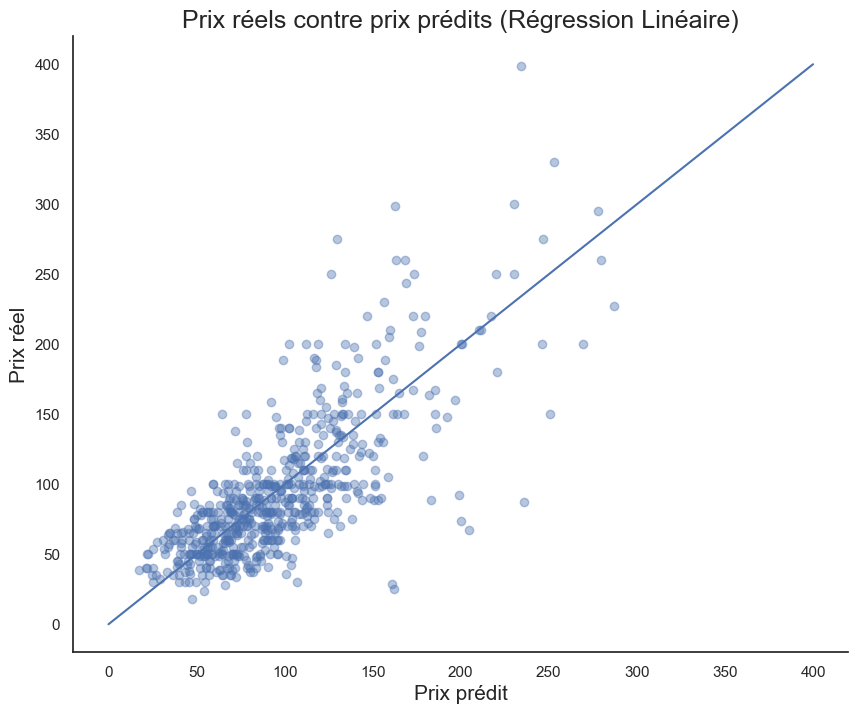

In [148]:
plt.figure(figsize=(10, 8))
plt.plot([0,400], [0,400], )
plt.scatter(val_pred, y_val, alpha=0.4)
sns.despine()
plt.ylabel('Prix réel', size=15)
plt.xlabel('Prix prédit', size=15)
plt.title('Prix réels contre prix prédits (Régression Linéaire)', size=18);
plt.savefig('actual_plot', bbox_inches ='tight', dpi = 400)

Les points sont assez proches du tracé de la fonction identité. C'est assez cohérent avec la valeur du R^2 calculée. On observe une dispersion pour les prix les plus élevés, qui sont souvent plus faibles dans leur valeur prédite que leur valeur réelle.

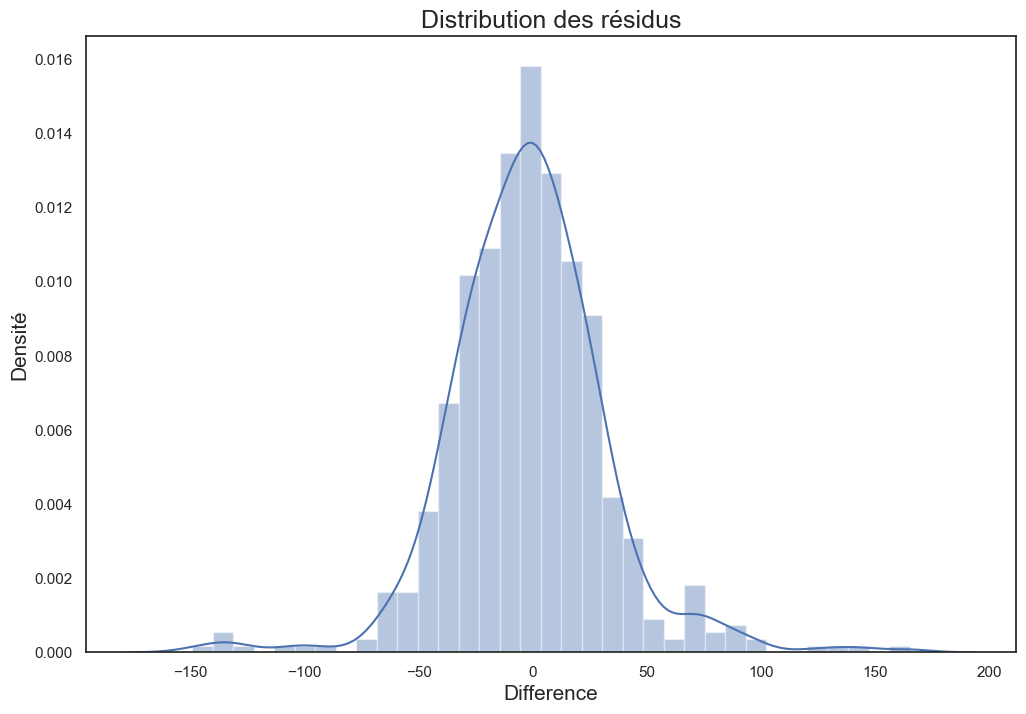

In [149]:
plt.figure(figsize=(12,8))
sns.distplot(y_val - val_pred) 
plt.title('Distribution des résidus', size = 18)
plt.xlabel('Difference', size = 15);
plt.ylabel('Densité', size = 15);
plt.savefig('residuals', bbox_inches ='tight', dpi = 400);

Les résidus semblent plutôt être distribués selon une loi normale centrée en 0. Cohérent avec l'hypothèse habituelle de normalité des termes d'erreur.

Pour éviter l'overfitting et améliorer notre modèle, on passe à une partie de regularisation, via les méthodes de Lasso et Ridge. Le but sera de minimiser le biais et la variance, sans en privilégier un en particulier.

### 2.5 Regularisation

####  2.5.1 Lasso

On ajoute un terme de pénalité en norme L1, ici noté alpha.

In [150]:
kf = KFold(n_splits=5, shuffle=True, random_state = 21)

alphavec = 10**np.linspace(-3,3,500)

lasso_model = LassoCV(alphas = alphavec, cv=kf)

lasso_model.fit(X_train_scaled, y_train)

print('LassoCV alpha:', lasso_model.alpha_)

print(f'LassoCV train R^2: {lasso_model.score(X_train_scaled, y_train):.3f}')
print(f'LassoCV validation R^2: {lasso_model.score(X_val_scaled, y_val):.3f}')

train_pred = lasso_model.predict(X_train_scaled)
y_val_pred = lasso_model.predict(X_val_scaled)

print('EMA pour le train en LassoCV:', round(mean_absolute_error(y_train, train_pred),4))
print('EMA pour la validation en LassoCV:', round(mean_absolute_error(y_val, y_val_pred),4))

LassoCV alpha: 0.24705040554568256
LassoCV train R^2: 0.592
LassoCV validation R^2: 0.567
EMA pour le train en LassoCV: 25.3702
EMA pour la validation en LassoCV: 24.3074


Les R^2 restent semblables à ceux qu'on avait obtenus avant (on n'a pas ajouté ou enlevé de variable explicative, donc cohérent) ; l'erreur moyenne absolue reste semblable à celle trouvée juste avant. Le alpha vaut 0.14, donc les coefficients ont une valeur incluse entre 0 et celle de la régression simple. Plus alpha augmente, plus les coefficients tendent vers 0 à cause de la pénalité.

De même, on trace les prix réels en comparaison avec ceux prédits.

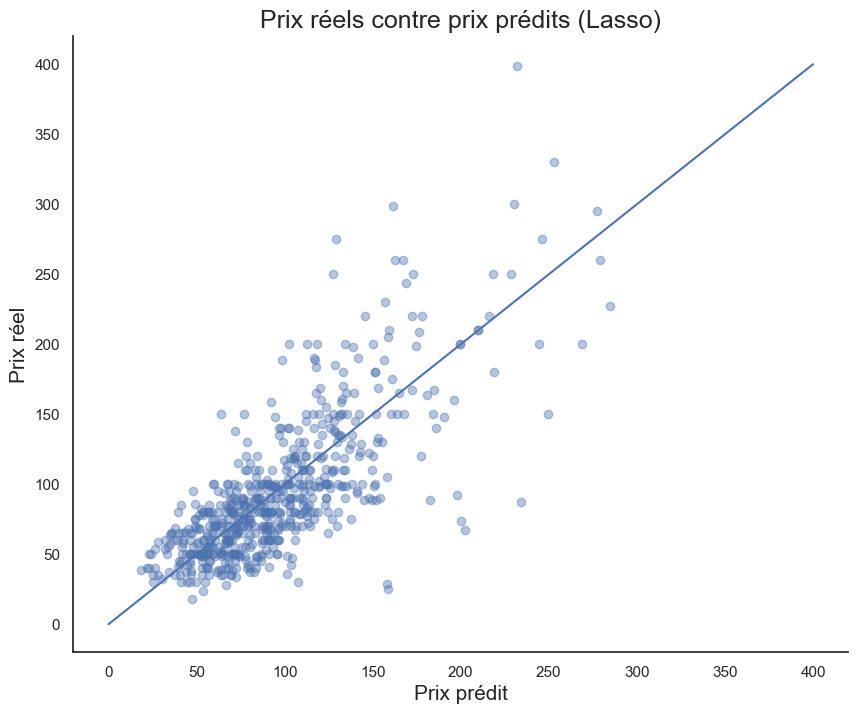

In [151]:
plt.figure(figsize=(10, 8))
plt.plot([0,400], [0,400])
plt.scatter(y_val_pred, y_val, alpha=0.4)
sns.despine()
plt.ylabel('Prix réel', size=15)
plt.xlabel('Prix prédit', size=15)
plt.title('Prix réels contre prix prédits (Lasso)', size=18);
plt.savefig('actual plot', bbox_inches ='tight', dpi = 400)

On remarque la même chose que précedemment : la plupart des prix sont assez proches de la droite identité, mais quand ils augmentent, ils tendent plus souvent à être plus grands dans leur valeur réelle que prédite. 

#### 2.5.2 Ridge

Le terme de pénalité passe maintenant sous norme 2.

In [152]:
alphavec = 10**np.linspace(-3,3,500)

ridge_model = RidgeCV(alphas = alphavec, cv=kf)

ridge_model.fit(X_train_scaled, y_train)

print('Ridge alpha:', ridge_model.alpha_)

print(f'RidgeCV train R^2: {ridge_model.score(X_train_scaled, y_train):.3f}')
print(f'RidgeCV validation R^2: {ridge_model.score(X_val_scaled, y_val):.3f}')

train_pred = ridge_model.predict(X_train_scaled)
y_val_pred = ridge_model.predict(X_val_scaled)

print('EMA du Train pour Ridge:', round(mean_absolute_error(y_train, train_pred),4))
print('EMA de Validation pour Ridge :', round(mean_absolute_error(y_val, y_val_pred),4))

Ridge alpha: 85.08631582640582
RidgeCV train R^2: 0.592
RidgeCV validation R^2: 0.567
EMA du Train pour Ridge: 25.3598
EMA de Validation pour Ridge : 24.2752


Les R^2 restent semblables à ceux qu'on avait obtenus ; l'erreur moyenne absolue reste également similaire à celle trouvée juste avant. Le alpha vaut 48, donc les coefficients ont une valeur incluse entre 0 et celle de la régression simple, plus proches de 0 qu'avec le Lasso.

### 2.6 Coefficients de la régression linéaire

Nous nous intéressons maintenant à la visualisation de l'importance de chaque feature, pour déterminer ce qui influence le plus les prix des Airbnb. Voici d'abord les coefficients numériques, puis leur représentation graphique.

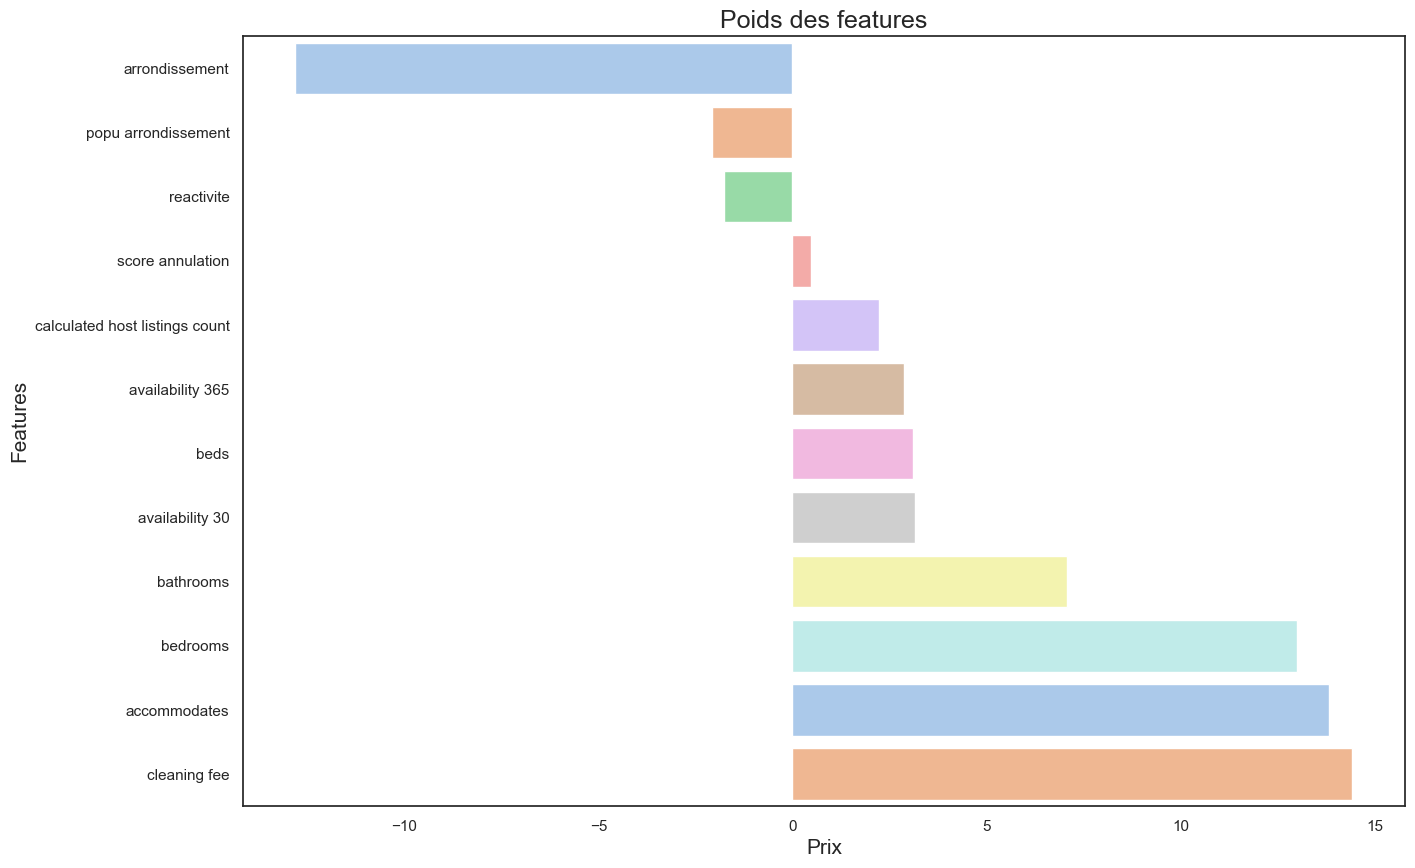

In [153]:
coef_list = sorted(list(zip(X_train.columns, lr.coef_)), key= lambda x : x[1])

x_values = [x[0] for x in coef_list]
y_values = [y[1] for y in coef_list]

fig, ax = plt.subplots(figsize=(15,10))
ax = sns.barplot(x=y_values, y=x_values, palette=("pastel"))
#ax.set(xticks=xtick_list)
ax.set_title('Poids des features', size=18)
ax.set_xlabel('Prix', size=15)
ax.set_ylabel('Features', size=15)
plt.savefig('features', bbox_inches ='tight', dpi = 400)

In [154]:
coefs_df = pd.DataFrame(columns=['Feature', 'Coefficient'])
coefs_df['Feature'] = x_values
coefs_df['Coefficient'] = y_values
coefs_df.to_csv('lr_coefs.csv')
coefs_df

,Feature,Coefficient
0,arrondissement,-12.804712
1,popu arrondissement,-2.060428
2,reactivite,-1.764815
3,score annulation,0.480870
4,calculated host listings count,2.231410
5,availability 365,2.871221
6,beds,3.112498
7,availability 30,3.168201
8,bathrooms,7.073488
9,bedrooms,13.017793


Comme vu précedemment, les frais de ménage, le nombre de chambre, la capacité d'accueil et la disponibilité sont des facteurs clés pour le prix. Cependant, nous gardons des réserves sur l'interprétation de la variable arrondissement : elle a réellement une influence, mais elle est assez dure à lire car les arrondissements sont classés de 1 à 20, mais cela ne reflète pas leur attractivité pour les clients Airbnb.

### 2.7 Modélisation avec XGBoost

On passe maintenant à une partie liée à la méthode de gradient boosting. On ne s'attachera pas trop à expliquer la théorie (cf cours du second semestre en 2A à l'ENSAE), mais cette méthode est censée donner de meilleurs modèles, plus précis et avec moins d'erreurs, en s'appuyant sur des arbres de décision. On prend des paramètres "classiques" puis on recherchera les meilleurs dans la partie suivante.

In [155]:
eval_set = [(X_val, y_val)]

In [156]:
gbm = xgb.XGBRegressor( 
                       n_estimators=10000, #arbitrary large number
                       max_depth=7,
                       objective="reg:squarederror",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.6
                      )

eval_set=[(X_train,y_train),(X_val,y_val)] 

xgb_reg = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='mae',
                    early_stopping_rounds=20,
                    verbose=100 #gives output log as below
                   )

[0]	validation_0-mae:87.06069	validation_1-mae:84.19703
[50]	validation_0-mae:12.78993	validation_1-mae:22.09236


In [157]:
test_pred = xgb_reg.predict(X_test)
print('EMA du Test:', round(mean_absolute_error(y_test, test_pred),4))

EMA du Test: 22.2852


L'erreur moyenne absolue est plus basse que les modèles précedents ; le modèle est donc un peu plus précis.

### 2.8 GridSearchCV pour trouver les meilleurs paramètres

In [ ]:

xgb_param_grid = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1],
    'n_estimators': [1000],
    'colsample_bytree':[0.5,0.75],
    'colsample_bylevel':[0.25,0.5],  
}

xgb_gridsearch = GridSearchCV(xgb.XGBRegressor(),
                           xgb_param_grid,
                           cv=5,
                           n_jobs=-1)

xgb_gridsearch.fit(X_train, y_train)

In [ ]:
best_xgb = xgb_gridsearch.best_estimator_

In [ ]:
test_pred = best_xgb.predict(X_test)
print('EMA Test:', round(mean_absolute_error(y_test, test_pred),4))

L'erreur moyenne absolue trouvée est de 23.29 environ, c'est meilleur que ce que l'on a trouvé précedemment. Cohérent.
On obtient donc les paramètres optimaux suivants : 

In [ ]:
best_xgb

On obtient, enfin, le tracé du "classement (poids)" de l'importance de 12 features avec XGBoost.

In [ ]:
feat_df = pd.DataFrame(list(zip(X_train.columns, best_xgb.feature_importances_)), 
                       columns=['Feature', 'Weight'])

In [ ]:
feat_df = feat_df.sort_values(by=['Weight'], ascending=False)

In [ ]:
top_10 = feat_df.head(12)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x=top_10['Weight'], y=top_10['Feature'], palette = "pastel")
plt.xlabel('Poids')
plt.ylabel('Features')
ax.set_title('Importance des features (XGBoost)');

Ensuite, on décide d'utiliser le module 'shap' pour encore mieux interpréter les outputs du modèle.

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train,max_display=30)

Ce graphe nous apporte plusieurs informations : 
- chaque couleur représente la valeur d'une feature (basse ou haute)
- on voit horizontalement, pour chaque feature, la distripution des valeurs de Shapley, qui explique la contribution de chaque feature à la prédiction. 
Par exemple, une petite capacité d'accueil réduit la valeur prédite du prix par nuit, et à l'inverse une grande capacité l'augmente.
De même, une grande valeur de la variable 'réactivité' (qui est enfait le manque de réactivité, en vue de la façon dont cela a été codé) réduit le prix prédit, alors qu'une grande réactivité (donc petite valeur de 'réactivité') l'augmente.
C'est assez cohérent avec ce qui a été vu précedemment, et également assez cohérent avec la logique des réservations Airbnb.

In [ ]:
X_display, y_display = shap.datasets.adult(display=True)

On calcule l'explainer expected value, qui correspond à la moyenne de l'output pour tous les inputs possibles.

In [ ]:
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

In [ ]:
select = range(20,50)
features = X_test.iloc[select]
features_display = X_test.iloc[select]

In [ ]:
shap_values = explainer.shap_values(features)[1]

In [ ]:
shap.decision_plot(expected_value, shap_values, features_display)

Ce graphique nous montre comment chaque feature contribue au prix prédit pour une nuit. Les observations convergent en bas du graphique, à la valeur "explainer.expected_value".


## 3. Amélioration du modèle

Jusqu'ici, nous avons négligé la colonne 'Amenities' par simplification. Cette variable contient toutes les caractéristiques plus spécifiques des appartements (accès à la Wifi, kitchenette, télévisions avec beaucoup de chaînes ou simplement TNT...), qui peuvent expliquer une hausse du prix d'un appartement.

In [ ]:

df['Amenities'].describe()


Un premier problème apparaît lorsque l'on essaye d'exploiter la variable « amenities » : tous les équipements en question sont groupés en format texte pour chaque observation. Ainsi, pour chaque observation, on aimerait dans un premier temps créer une variable différente pour chaque équipement. Puis, dans un second temps, créer des indicatrices pour chaque variable.

In [ ]:
#On commence par convertir la variable en format string 
df = df.astype({'Amenities' : 'string'})

In [ ]:
# On sépare ensuite chacun des équipements pour chaque observation

def indic_amenities(s):
    return len(s.split(','))

df['num_Amenities'] = df['Amenities'].apply(indic_amenities)

In [ ]:
Amenities = " ".join(list(df.Amenities))
Amenities = Amenities.replace('{', '')
Amenities = Amenities.replace('}', ',')
Amenities = Amenities.replace('"', '')
amenities_split = [x.strip() for x in Amenities.split(',')]
amenities_split = set(amenities_split)
amenities_tr = list(amenities_split)
amenities_tr

for k in amenities_tr :
    df[k] = df['Amenities'].str.contains(k).astype(int)


print(df.shape)


amenities_tr

On obtient dès lors une liste d'éléments qui correspondent chacun à un équipement spécifique. Comme on va le vérifier juste après, ces variables sont désormais quantitatives : ce sont des indicatrices.

In [ ]:
amenities_df = df.iloc[:,-10000:]
amenities_df['Price'] = df['Price']

In [ ]:
amenities_df[['Internet', 'TV', 'Cable TV', 'Heating', 'Kitchen', 'Washer', 'Elevator in building']].head()

Par exemple, on peut s'intéresser à l'influence du fait de posséder (ou non) les chaînes de télévision de la TNT sur le prix moyen de la nuit.

In [ ]:
index = 1
fig = plt.figure(1, figsize=(20,50))
internet_amenities = amenities_tr[11:12]
colors = ['powderblue','lightpink']
for name in internet_amenities:
    
    current_axis = fig.add_subplot(1,2,index)
    pmoy0 = df[df[name] == 0]['Price'].mean()
    pmoy1 = df[df[name] == 1]['Price'].mean()

    x = ['Sans', 'Avec']
    y = [pmoy0, pmoy1]

    ax = sns.barplot(x=x,y=y, palette=colors);
    title = 'Prix moyen du airbnb avec ou sans les chaînes de la TNT' 
    ax.set_title(title, size=15)
    ax.set_xticklabels(['Sans', 'Avec'], size=15)
    ax.set_ylabel('Prix', size = 15)
    index +=1

Le résultat obtenu est certes qualitatif, mais il nous donne un premier aperçu de ce qui peut nous sembler assez intuitif : les logements les mieux équipés (ici, équipés d'une offre de chaînes de télévision) sont tendanciellement plus chers. Néanmoins, ces seules statistiques descriptives ne nous permettent pas de déterminer la significativité statistique du résultat. Pour ce faire, il faudrait de nouveau utiliser la modélisation de la partie précédente en intégrant tous les nouveaux éléments relatifs aux équipements. Certains écueils restent toutefois à éviter. En particulier, il faut faire attention à ne pas trop « surcharger » les modèles de régression standards, au risque d'induire des biais liés à l'overfitting. Dans ce cas là, les méthodes de régressions pénalisées (Lasso, Ridge) ou celles de gradient boosting (XGBoost) sont préférables.

# Conclusion 

Ce projet avait pour but de prédire les prix des Airbnb parisiens et de les comparer, dans une moindre mesure, aux loyers parisiens. Grâce à des statistiques descriptives, cartes interactives et analyses NLP, nous avons pu concevoir une idée des features qui influencaient le plus ces prix. 
Nous avons ensuite construit notre modèle, en nous appuyant sur diverses méthodes, certaines plus avantageuses mais aussi plus complexes que les autres.
Enfin, nous avons trouvé une piste d'amélioration de notre modèle, en incluant les équipements des appartements.
Dans l'idéal, nous pourrions inclure ces nouvelles features dans le modèle, même si les risques d'overfitting persistent dans le cas de régressions classiques.
Nous aurions aimé avoir des données plus récentes (la plupart ont été scrappées en avril 2017), pour voir l'évolution des prix depuis la pandémie du Covid-19. De même, les prix de l'immobilier provenant du scrapping que nous avons effectués sont des prix actuels. Nous nous interrogeons sur la pertinence de cette comparaison, mais pensons quand même que les prix sont restés relativement stables.
De plus, nous nous questionnons sur l'utilisation ou non de subsets dans la partie modélisation, mais pensons qu'ils sont quand même pertinents et plus faciles à manier.
Enfin, nous pensons avoir appliqué la majorité des points vus en cours, et sommes satisfaits d'avoir appris tout cela.
